In [1]:
pip install pyspark
pip install pandas
pip install sklearn

     |████████████████████████████████| 215.7MB 166kB/s  eta 0:00:01
     |████████████████████████████████| 204kB 38.1MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark
  Found existing installation: py4j 0.10.8.1
    Uninstalling py4j-0.10.8.1:
      Successfully uninstalled py4j-0.10.8.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = "--master local[2] pyspark-shell"
os.environ['JAVA_HOME'] = "/usr/local/java/jdk1.8.0_221"

In [2]:
from __future__ import print_function

import sys
if sys.version >= '3':
    long = int

from pyspark.sql import SparkSession

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.mllib.recommendation import MatrixFactorizationModel
from pyspark.sql import Row
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble, metrics

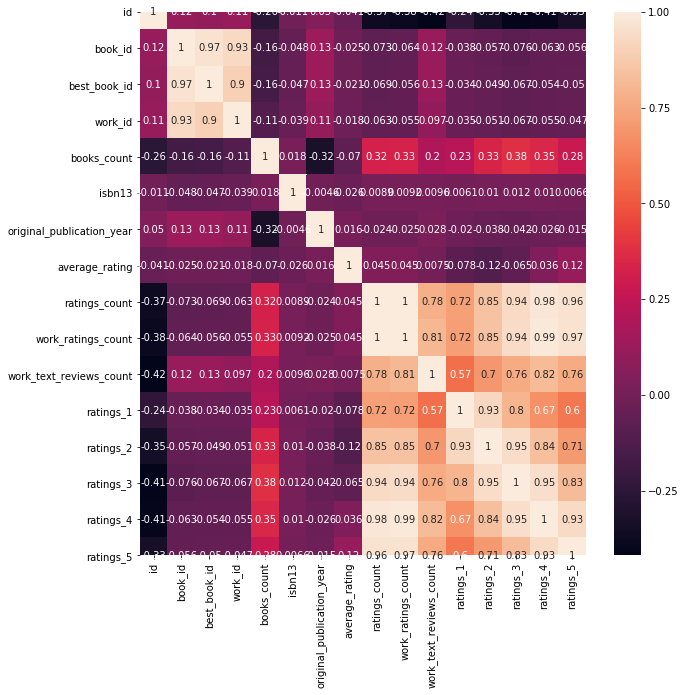

In [5]:
df = pd.read_csv("file:///root/infs3208/data/books.csv")
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True,ax=ax)
plt.show()

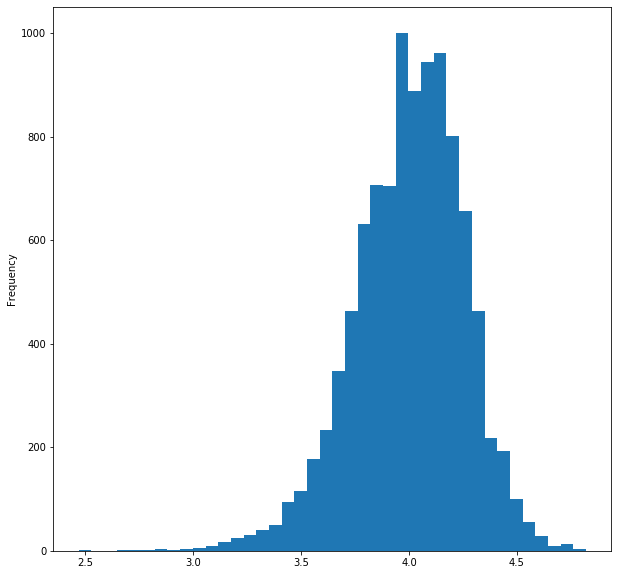

In [6]:
df.average_rating.plot(kind= 'hist', bins = 40, figsize = (10,10))
plt.show()

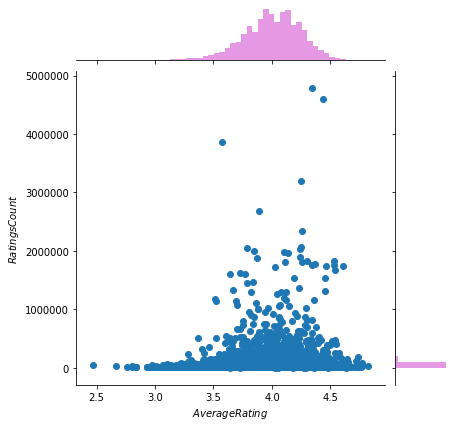

In [7]:
g = sns.jointplot(x="average_rating", y="ratings_count", data=df, kind="scatter", color="m")
g.plot_joint(plt.scatter, linewidth=1)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Average Rating$", "$Ratings Count$")

In [9]:
spark = SparkSession\
        .builder\
        .appName("BookRecommender")\
        .getOrCreate()

In [30]:
import os
import subprocess

cmd = 'hdfs dfs -ls /projectdata'
subprocess.check_output(cmd, shell=True)

b'Found 2 items\n-rw-r--r--   2 root supergroup    3286722 2019-09-27 05:15 /projectdata/books.hdfs.csv\n-rw-r--r--   2 root supergroup   12437766 2019-09-27 05:16 /projectdata/ratings.hdfs.csv\n'

In [31]:
ratings = spark.read.text("hdfs:/projectdata/ratings.hdfs.csv").rdd

In [32]:
print(ratings.take(5))

[Row(value='book_id,user_id,rating'), Row(value='1,314,5'), Row(value='1,439,3'), Row(value='1,588,5'), Row(value='1,1169,4')]


In [33]:
partitions = ratings.map(lambda row: row.value.split(","))

In [34]:
header = partitions.first()
ratingsRDD = partitions.filter(lambda line: line != header)

In [35]:
ratings_final_RDD = ratingsRDD.map(lambda p: Row(bookId= int(p[0]), userId= int(p[1]), rating=int(p[2])))

In [36]:
ratingsDF = spark.createDataFrame(ratings_final_RDD)

In [38]:
(training, test) = ratingsDF.randomSplit([0.8, 0.2])

In [39]:
als = ALS(maxIter=10, regParam=0.1, userCol="userId", itemCol="bookId", ratingCol="rating",
              coldStartStrategy="drop")

In [41]:
model = als.fit(training)

In [42]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))


Root-mean-square error = 0.9050359548837524


In [43]:
# Generate top 10 book recommendations for each user
userRecs = model.recommendForAllUsers(10)

# Generate top 10 user recommendations for each book
bookRecs = model.recommendForAllItems(10)

In [44]:
print(userRecs.show(10))

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   148|[[9842, 4.6246815...|
|   463|[[3628, 5.1201105...|
|   471|[[7789, 3.512369]...|
|   496|[[6659, 5.803503]...|
|   833|[[9006, 5.15239],...|
|  1088|[[9537, 4.720115]...|
|  1238|[[6928, 4.101072]...|
|  1342|[[4868, 4.985993]...|
|  1580|[[2840, 5.045147]...|
|  1591|[[4609, 4.853213]...|
+------+--------------------+
only showing top 10 rows

None


In [45]:
bookRecs.show()

+------+--------------------+
|bookId|     recommendations|
+------+--------------------+
|  1580|[[6231, 5.4014997...|
|  4900|[[37060, 5.371372...|
|  5300|[[19564, 5.144178...|
|  6620|[[52453, 5.834347...|
|  7240|[[28953, 5.915947...|
|  7340|[[41168, 5.753499...|
|  7880|[[46127, 5.472051...|
|  9900|[[20961, 5.863566...|
|   471|[[48001, 5.361287...|
|  1591|[[50307, 5.845510...|
|  4101|[[16060, 5.218403...|
|  1342|[[20961, 6.178701...|
|  2122|[[49360, 5.250336...|
|  2142|[[50307, 5.527193...|
|  7982|[[27969, 5.296842...|
|  8592|[[15077, 5.752313...|
|  9852|[[30757, 5.359214...|
|   463|[[30757, 6.469635...|
|   833|[[30757, 5.110815...|
|  5803|[[9139, 5.0525255...|
+------+--------------------+
only showing top 20 rows



In [46]:
spark.stop()